# MFCC features

This notebook contains the process of computing the MFCC features alongside figure generation functions for the diploma thesis. 

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import wave
import os
from scipy.fftpack import dct
from scipy.signal.windows import boxcar

In [9]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

In [3]:
test_wav = './yellow_dandelion.wav'

## Normalization + plotting

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


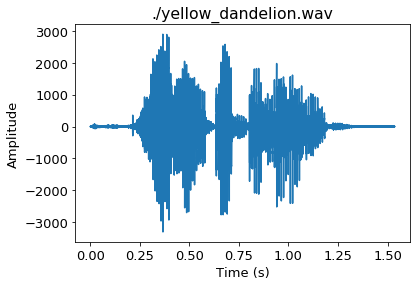

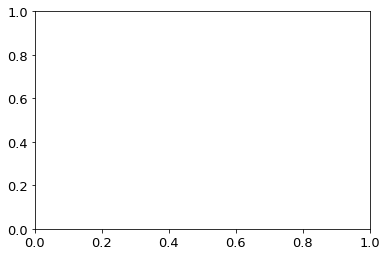

In [4]:
def normalize_signal(signal, bits_per_sample=16):
    return [(sample/2**bits_per_sample)*2 for sample in signal]

def plot_signal(signal, framerate, title='', export_name=None):
    y_time = np.linspace(0, len(signal) / framerate, num=len(signal))
    f = plt.figure(1)
    plt.plot(y_time, signal)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    if export_name:
        if not os.path.exists('./figures/'): os.mkdir('./figures/')
        plt.title('')
        f.savefig('./figures/' + str(export_name), bbox_inches='tight')

def plot_wav_file(filename):
    spf = wave.open(filename, 'r')
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    #norm_signal = normalize_signal(signal)
    fr = spf.getframerate()

    if spf.getnchannels() != 1:
        print('Audio file has', spf.getnchannels(), 'channels, returning...')
        return

    plot_signal(signal, fr, filename, 'signal.pdf')

plot_wav_file(test_wav)

## Opening file, getting metadata

In [5]:
spf = wave.open(test_wav, 'r')
signal = np.frombuffer(spf.readframes(-1), np.int16)
framerate = spf.getframerate()

## Pre-emphasis

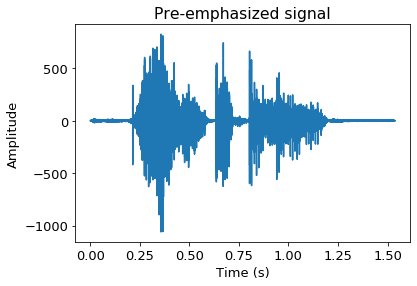

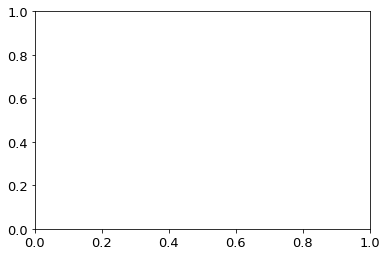

In [6]:
def pre_emphasize(signal, alpha):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1]).astype(np.int16)

plot_signal(pre_emphasize(signal, 0.97), framerate, 'Pre-emphasized signal', 'preemph_signal.pdf')

In [7]:
def write_signal_file(signal, ref_wave_obj, filename='test.wav'):
    test_wav = wave.open('lmao_test.wav', 'w')
    test_wav.setnchannels(ref_wave_obj.getnchannels())
    test_wav.setsampwidth(ref_wave_obj.getsampwidth())
    test_wav.setframerate(ref_wave_obj.getframerate())
    test_wav.setcomptype(ref_wave_obj.getcomptype(), 'NONE')
    test_wav.setsampwidth(ref_wave_obj.getsampwidth())
    test_wav.writeframesraw(signal)
    test_wav.close()

## Framing
Cutting signal into speech frames. 

Typically 20 ms to 40 ms with 50% (+/-10%) overlap (size - stride) between consecutive frames

In [8]:
def frame_signal(signal, framerate, frame_size=0.025, frame_stride=0.01):
    #frame_size = 0.025 # 25 ms cuts
    #frame_stride = 0.01 # 10 ms step => 15 ms overlap

    frame_length, frame_step = int(round(frame_size * framerate)), \
                               int(round(frame_stride * framerate))  # seconds -> samples
    signal_length = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # at least 1

    padded_signal_length = num_frames * frame_step + frame_length # length with neccessary padding (for equal length of frames)
    padding = np.zeros((padded_signal_length - signal_length)) # the padding itself
    padded_signal = np.append(signal, padding) # pad the signal before cutting

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T # sequences of indeces for each frame - 2D matrix, where lines are individual frames

    return padded_signal[indices.astype(np.int32, copy=False)]

signal_1_framed = frame_signal(signal, framerate)

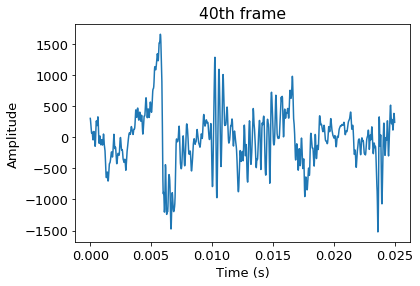

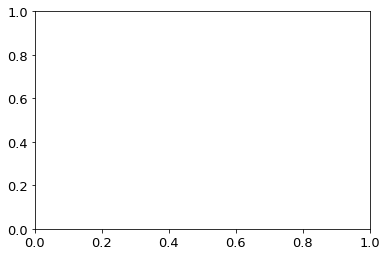

In [9]:
frame_fourty = signal_1_framed[40]
plot_signal(frame_fourty, framerate, '40th frame', '40th_frame.pdf') # 40th frame  ->  0.4-0.425 seconds

## Hamming windows

In [10]:
def hamming_windows(frames):
    if frames.ndim == 2:
        return frames * np.hamming(len(frames[0]))
    else:
        return frames * np.hamming(len(frames))

signal_2_windowed = hamming_windows(signal_1_framed)

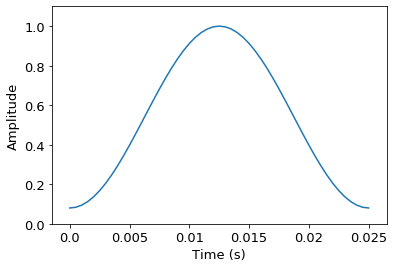

In [11]:
window = np.hamming(51)
f = plt.figure(1)
x1,x2,y1,y2 = plt.axis()
plt.axis((-3,53,0.0,1.1))
plt.xticks(np.linspace(0, 50, 6), np.linspace(0.000, 0.025, 6))
plt.plot(window)
plt.title('')
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.show()
f.savefig('./figures/hamming.pdf', bbox_inches='tight')

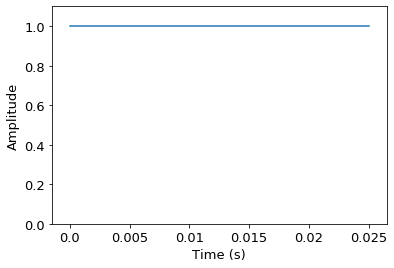

In [12]:
window = boxcar(51)
f = plt.figure(1)
x1,x2,y1,y2 = plt.axis()
plt.axis((-3,53,0.0,1.1))
plt.xticks(np.linspace(0, 50, 6), np.linspace(0.000, 0.025, 6))
plt.plot(window)
plt.title('')
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.show()
f.savefig('./figures/rectangular.pdf', bbox_inches='tight')

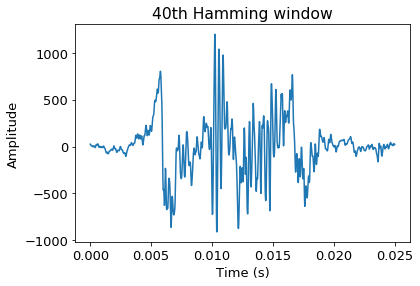

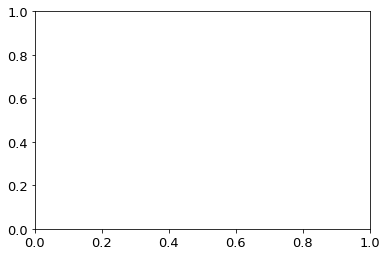

In [13]:
frame_fourty = hamming_windows(frame_fourty)
plot_signal(frame_fourty, framerate, '40th Hamming window', '40th_hamming.pdf')

## Discrete Fourier Transform

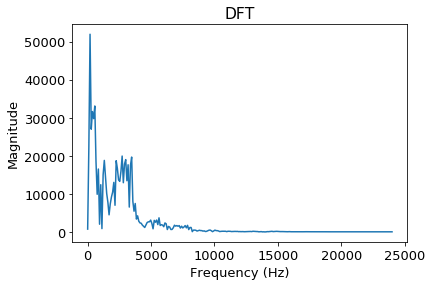

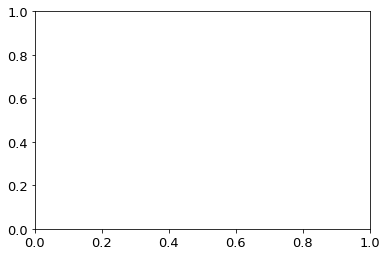

In [14]:
def fourier(frames, n_points=512, plot=False, title='DFT'):
    yf = np.absolute(np.fft.rfft(frames, n=n_points)).real.transpose()
    if plot:
        T = 1/framerate
        xf = np.linspace(0.0, 1.0/(2.0*T), n_points/2 + 1)
        f = plt.figure(1)
        plt.title(title)
        plt.plot(xf, yf)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.show()
        plt.title('')
        f.savefig('./figures/dft.pdf', bbox_inches='tight')
    return yf
    
signal_3_fourier = fourier(signal_2_windowed, plot=False)
_ = fourier(frame_fourty, plot=True)

## Filter banks - Mel-Scale

In [15]:
def freq_to_mel(frequency):
    return 1127*np.log(1 + frequency/700)

def mel_to_freq(mel):
    return 700*(np.exp(mel/1127) - 1)

In [16]:
def mel_scale_filter(frames, n_filters=26, nfft_points=512, min_mel=0, max_mel=freq_to_mel(framerate/2)):
    # max_mel is standardly set to mel(framerate/2) as a maximum mel for the given framerate
    mel_points = np.linspace(min_mel, max_mel, n_filters + 2)  # equally spaced points in Mel space
    freq_points = mel_to_freq(mel_points) # convert those point to Hz

    bins = np.floor((nfft_points + 1) * freq_points / framerate) # 
    filter_banks = np.zeros((n_filters, int(np.floor(nfft_points/2 + 1))))
    
    for p in range(1, n_filters + 1):
        lower_bin = int(bins[p - 1])
        center_bin = int(bins[p])
        upper_bin = int(bins[p + 1])

        # fill the apropriate parts of filter banks with non zero values
        for k in range(lower_bin, center_bin): # increasing part
            filter_banks[p - 1, k] = (k - bins[p - 1]) / (bins[p] - bins[p - 1])
        for k in range(center_bin, upper_bin): # decreasing part
            filter_banks[p - 1, k] = (bins[p + 1] - k) / (bins[p + 1] - bins[p])
    
    result = np.dot(frames.T, filter_banks.T) # matrix multiplication
    result = np.where(result == 0, np.finfo(float).eps, result) # substitute zeros with minimal recognizable float value
    return 20 * np.log10(result)  # dB
    #return result

In [17]:
def print_spectrogram(frames, title='', export_name=None):
    f = plt.figure(figsize=(16,5))
    plt.title(title)
    _ = plt.imshow(frames.T, origin='lower')
    plt.show()
    if export_name:
        plt.title('')
        f.savefig('./figures/' + str(export_name), bbox_inches='tight')

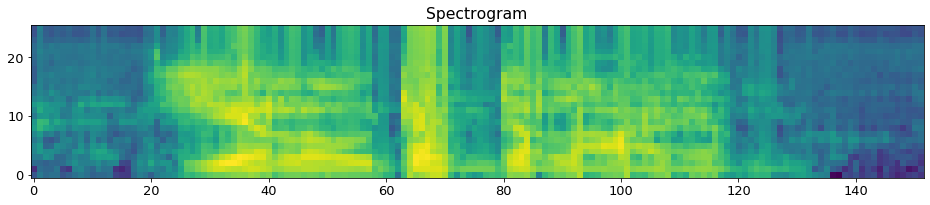

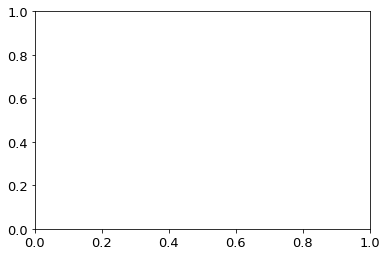

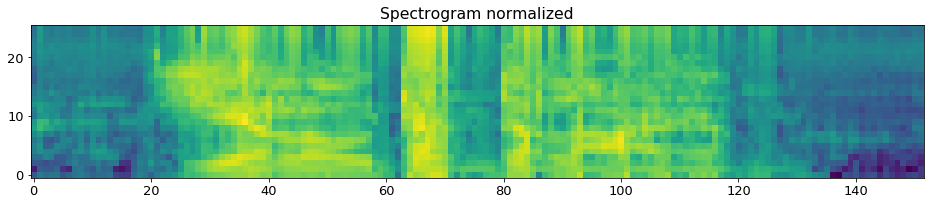

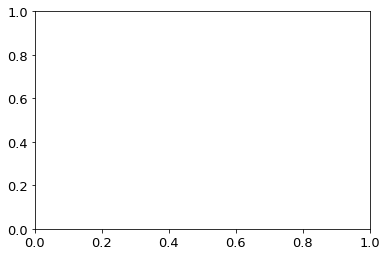

In [18]:
signal_4_mel = mel_scale_filter(signal_3_fourier, nfft_points=512, max_mel=freq_to_mel(24000))
print_spectrogram(signal_4_mel, 'Spectrogram', 'spectrogram.pdf')
print_spectrogram(signal_4_mel - np.mean(signal_4_mel, axis=0) + 1e-8, 'Spectrogram normalized', 'spectrogram_norm.pdf')

## Cepstral Coefficients
Filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks.

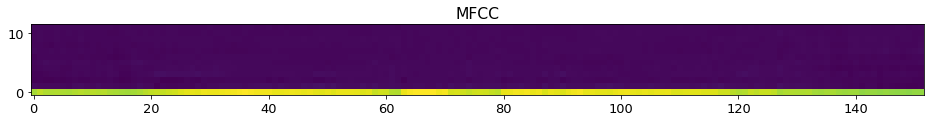

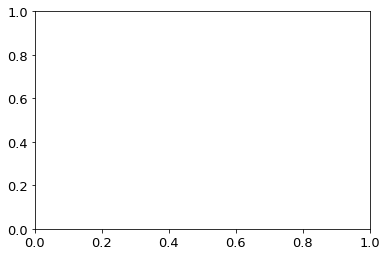

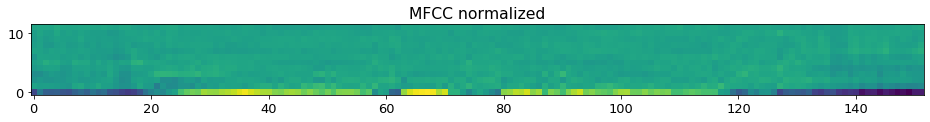

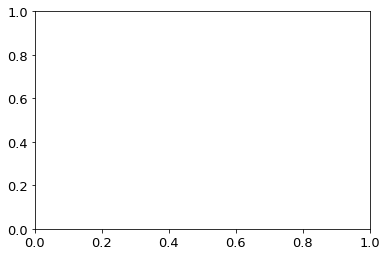

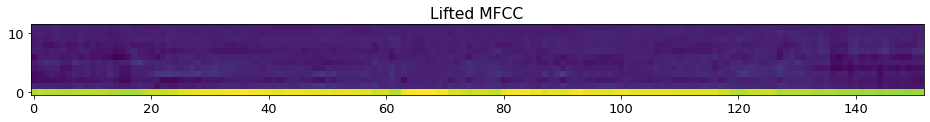

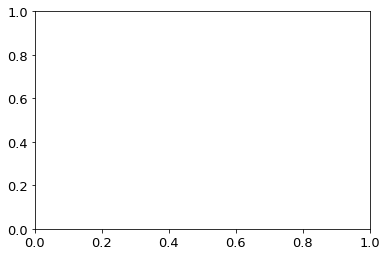

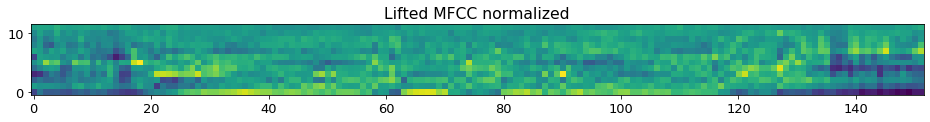

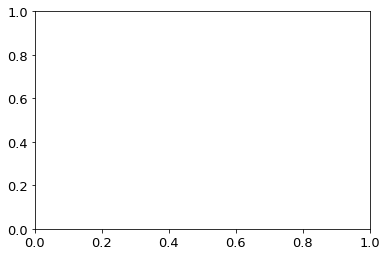

In [19]:
num_coeffs = 12

signal_5_cc = np.log(signal_4_mel)
signal_5_cc = np.fft.irfft(signal_5_cc)[:, 0 : (num_coeffs + 0)]

signal_5_cc_norm = signal_5_cc - (np.mean(signal_5_cc, axis=0) + 1e-8)

cep_lifter = 12
(nframes, ncoeff) = signal_5_cc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
signal_5_cc_lift = lift * signal_5_cc
signal_5_cc_norm_lift = lift * signal_5_cc_norm

print_spectrogram(signal_5_cc, 'MFCC', 'mfcc.pdf')
print_spectrogram(signal_5_cc_norm, 'MFCC normalized', 'mfcc_norm.pdf')

print_spectrogram(signal_5_cc_lift, 'Lifted MFCC', 'mfcc_lift.pdf')
print_spectrogram(signal_5_cc_norm_lift, 'Lifted MFCC normalized', 'mfcc_norm_lift.pdf')

## A parametric Haar wavelet function
Served as a figure generator for the diploma thesis

In [20]:
def haar_xy(a, b, plot=True, export_name='haar'):
    if not a:
        print("Parameter \"a\" must be non-zero.")
        return
    x_step = np.abs(a)*0.5
    y_step = 1/a
    left_lim = min(0-x_step, b-x_step)
    right_lim = max(0+x_step, b+3*x_step)
    
    left_x_padding = [] if left_lim == b-x_step else np.linspace(left_lim, b-x_step, (b-x_step-left_lim)/x_step)
    right_x_padding = [] if right_lim == b+3*x_step else np.linspace(left_lim, b-x_step, (right_lim-(b+3*x_step))/x_step)
        
    haar_x = np.append(np.append(left_x_padding, [b-x_step, b, b+x_step, b+x_step, b+2*x_step, b+3*x_step]), right_x_padding)
    haar_y = len(left_x_padding)*[0] + [0, 0, y_step, -y_step, -y_step, 0] + len(right_x_padding)*[0]
    
    if not plot:
        return haar_x, haar_y, x_step, y_step
    
    f = plt.figure(1)
    plt.xlabel('time(t)')
    haar_yl = plt.ylabel(r'$\psi_{PH}$'.replace('PH', str(a) + ',' + str(b)))
    haar_yl.set_rotation(0)
    plt.xlim(left_lim, right_lim)
    plt.yticks([-y_step, 0, y_step])
    plt.step(haar_x, haar_y)
    plt.grid()
    plt.show()
    
    if export_name:
        f.savefig('./figures/' + export_name + '.pdf', bbox_inches='tight')
    return

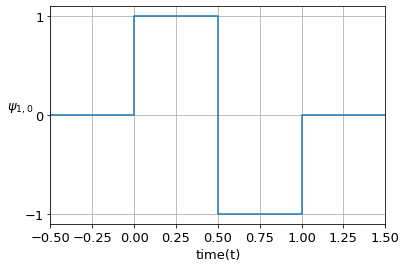

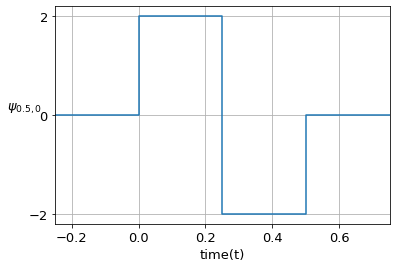

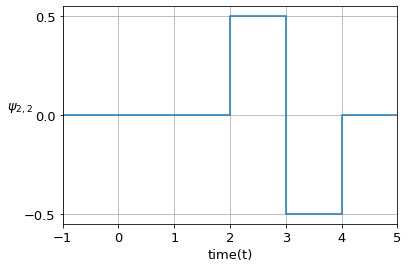

In [21]:
haar_xy(1, 0)
haar_xy(1/2, 0, export_name='haar_compressed')
haar_xy(2, 2, export_name='haar_dilated_translated')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


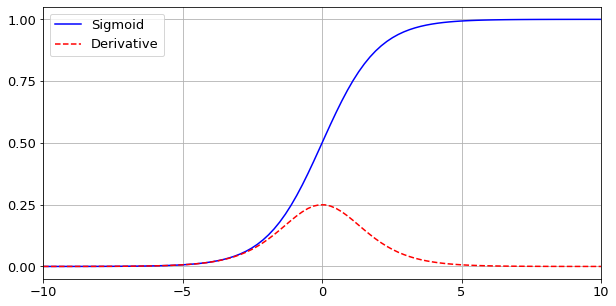

In [10]:
def sigmoid(x):
    sigmoid_return = 1 / (1 + np.exp(-x))
    return sigmoid_return

def dermoid(x):
    dermoid_return = sigmoid(x) * (1-sigmoid(x))
    return dermoid_return

x = np.linspace(-10,10,100)
y = np.linspace(0,1,10)

f = plt.figure(figsize=(10,5))
plt.plot(x, sigmoid(x), 'b', label = ' x linspace(-10,10,10)')
plt.plot(x, dermoid(x), '--r', label = ' x linspace(-10,10,10)')
plt.grid()
plt.legend(['Sigmoid', 'Derivative'])
plt.xlim(-10, 10)
plt.yticks(np.linspace(0, 1, 5))
plt.xticks(np.linspace(-10, 10, 5))
plt.savefig('./sigmoid_derivative.pdf')